In [1]:
from typing import Tuple
from functools import wraps

from IPython.display import display, Latex
from sympy import (
    init_printing, Expr, Symbol, symbols, I, pi, exp, Ynm, Abs, cos, sin, arg, sqrt, re, legendre,
    cancel, expand_func, simplify, expand, solve, lambdify,
)

init_printing()

In [2]:
# %% pads
coeff_s, coeff_p, coeff_d = symbols('c_s c_p c_d', positive=True)
eta_s, eta_p, eta_d = symbols('eta_s eta_p eta_d', real=True)
phi, theta, varphi = symbols('phi theta varphi', real=True)

waves = {
    'm=0': (coeff_s * exp(eta_s * I) * Ynm(0, 0, theta, varphi) +
            coeff_p * exp(eta_p * I + phi * I) * Ynm(1, 0, theta, varphi) +
            coeff_d * exp(eta_d * I) * Ynm(2, 0, theta, varphi)),
}
pads = {
    'm=0': Abs(waves['m=0']) ** 2,
    'summed': Abs(waves['m=0']) ** 2,
}

In [3]:
# %% solve pad eq
def expend_cos(expr: Expr, x: Symbol) -> Tuple[Expr, Expr]:
    while True:
        term = expr.subs(x, pi / 2)
        yield term
        expr = cancel((expr - term) / cos(x))
        if expr == 0:
            return


def amp_and_shift(expr: Expr, x: Symbol) -> Tuple[Expr, Expr]:
    amp = simplify(cancel(sqrt(expr ** 2 + expr.diff(x) ** 2).subs(x, 0)))
    shift = arg(expr.subs(x, 0) + I * expr.diff(x).subs(x, 0))
    return amp, shift


def solve_eq(pad: Expr) -> dict:
    # expand left term
    left = cancel(
        expand_func(pad)
            .subs(sin(theta) ** 2, 1 - cos(theta) ** 2)
    )
    terms_lft = tuple(expend_cos(left, theta))

    # expand right term
    b0, b1, b2, b3, b4 = symbols(
        'b_0 b_1 b_2 b_3 b_4',
        real=True
    )
    right = cancel(b0 +
                   b1 * legendre(1, cos(theta)) +
                   b2 * legendre(2, cos(theta)) +
                   b3 * legendre(3, cos(theta)) +
                   b4 * legendre(4, cos(theta)))
    terms_rgt = tuple(expend_cos(right, theta))

    # solve equations
    b4_cmpx = simplify(cancel(solve((terms_lft[4] - terms_rgt[4]), b4)[0]))
    b4_real = simplify(re(expand(b4_cmpx)))
    b3_cmpx = simplify(cancel(solve((terms_lft[3] - terms_rgt[3]), b3)[0]))
    b3_real = simplify(re(expand(b3_cmpx)))
    b3_amp, b3_shift = amp_and_shift(b3_real, phi)
    b2_cmpx = simplify(cancel(solve((terms_lft[2] - terms_rgt[2])
                                    .subs(b4, b4_cmpx), b2)[0]))
    b2_real = simplify(re(expand(b2_cmpx)))
    b1_cmpx = simplify(cancel(solve((terms_lft[1] - terms_rgt[1])
                                    .subs(b3, b3_cmpx), b1)[0]))
    b1_real = simplify(re(expand(b1_cmpx)))
    b1_amp, b1_shift = amp_and_shift(b1_real, phi)
    b0_cmpx = simplify(cancel(solve((terms_lft[0] - terms_rgt[0])
                                    .subs(b4, b4_cmpx)
                                    .subs(b2, b2_cmpx), b0)[0]))
    b0_real = simplify(re(expand(b0_cmpx)))
    b1m3_real = simplify(cancel(b1_real - b3_real * 2 / 3))
    b1m3_amp, b1m3_shift = amp_and_shift(b1m3_real, phi)
    return {
        'b0': b0_real,

        'b1': b1_real,
        'b1_amp': b1_amp,
        'b1_shift': b1_shift,
        'beta1': b1_real / b0_real,
        'beta1_amp': b1_amp / b0_real,
        'beta1_shift': b1_shift,

        'b2': b2_real,
        'beta2': b2_real / b0_real,

        'b3': b3_real,
        'b3_amp': b3_amp,
        'b3_shift': b3_shift,
        'beta3': b3_real / b0_real,
        'beta3_amp': b3_amp / b0_real,
        'beta3_shift': b3_shift,

        'b4': b4_real,
        'beta4': b4_real / b0_real,

        'b1m3': b1m3_real,
        'b1m3_amp': b1m3_amp,
        'b1m3_shift': b1m3_shift,
        'beta1m3': b1m3_real / b0_real,
        'beta1m3_amp': b1m3_amp / b0_real,
        'beta1m3_shift': b1m3_shift,
    }


solved = solve_eq(pads['summed'])

<IPython.core.display.Latex object>

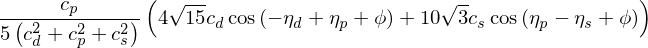

<IPython.core.display.Latex object>

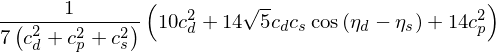

<IPython.core.display.Latex object>

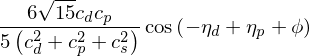

<IPython.core.display.Latex object>

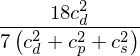

<IPython.core.display.Latex object>

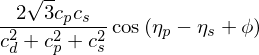

In [4]:
for k, v in [
        [r"$\beta_1=$", "beta1"],
        [r"$\beta_2=$", "beta2"],
        [r"$\beta_3=$", "beta3"],
        [r"$\beta_4=$", "beta4"],
        [r"$\beta_1-\frac{2}{3}\beta_3=$", "beta1m3"],
    ]:
    display(Latex(k))
    display(solved[f"{v}"])
    print()

<IPython.core.display.Latex object>

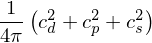

<IPython.core.display.Latex object>

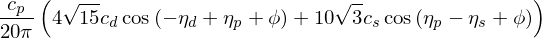

<IPython.core.display.Latex object>

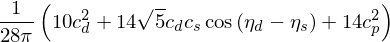

<IPython.core.display.Latex object>

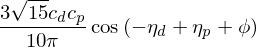

<IPython.core.display.Latex object>

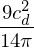

<IPython.core.display.Latex object>

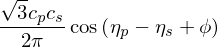

In [6]:
for k, v in [
        [r"$b_0=$", "b0"],
        [r"$b_1=$", "b1"],
        [r"$b_2=$", "b2"],
        [r"$b_3=$", "b3"],
        [r"$b_4=$", "b4"],
        [r"$b_1-\frac{2}{3}b_3=$", "b1m3"],
    ]:
    display(Latex(k))
    display(solved[f"{v}"])
    print()